In [ ]:
# 1. 데이터 로딩 및 전처리
import pandas as pd

df = pd.read_csv("36000_reviews_label.csv", encoding="utf-8-sig")
df = df[['sentence', 'label']].dropna()
df = df[df['label'].isin(['긍정', '부정', '중립'])]  # 3클래스 처리

# 텍스트와 라벨 분리
X = df['sentence'].fillna('')
y = df['label']


In [ ]:
# 2. 학습/테스트 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [31]:
from konlpy.tag import Okt

okt = Okt()

stopwords = list(set([
    '이', '가', '은', '는', '을', '를', '의', '에', '에서', '에게', '께', '로', '으로', 
    '와', '과', '보다', '처럼', '만큼', '같이', '까지', '마저', '조차', '부터', 
    '이나', '나', '이며', '며', '등', '하다', '한다', '하고', '하니', '하면', 
    '되어', '되다', '되고', '되니', '입니다', '습니다', 'ㅂ니다', '어요', '아요', '다', '방이', '제대로',
    '고', '면', '게', '지', '죠',
    '그리고', '그러나', '하지만', '그런데', '그래서', '그러면', '그러므로', '따라서', 
    '또한', '또는', '및', '즉', '한편', '반면에', '근데',
    '나', '저', '우리', '저희', '너', '너희', '당신', '그', '그녀', '그들', '누구', '그렇다',
    '무엇', '어디', '언제', '어느', '이것', '그것', '저것', '여기', '거기', '저기', 
    '이쪽', '그쪽', '저쪽',
    '하나', '둘', '셋', '넷', '다섯', '여섯', '일곱', '여덟', '아홉', '열',
    '일', '이', '삼', '사', '오', '육', '칠', '팔', '구', '십', '백', '천', '만',
    '첫째', '둘째', '셋째',
    '바로', '때', '것', '수', '문제', '경우', '방문','직원','마을','부분', '이다',
    '내용', '결과', '자체', '가지', '있다'
    '않았어요', '있었어요', '했어요', '했는데요', '있는데요', '합니다', '없다', '나다','생각하다',
    '했다', '같다', '네요','아니다',
    '좀', '너무', '정말', '많이', '조금',
    '사장', '이용', '용하다', '물이',
    '뿐', '대로', '만', '따름', '나름', '김에', '터',
    '아', '아이고', '아이구', '아하', '어', '그래', '응', '네', '예', '아니', '않다', '안되다','안','그냥',
    '가다', '오다', '주다', '말다', '나다', '받다', '알다', '모르다', '싶다', '생각하다', '들다'
]))

stopwords = set(w.lower() for w in stopwords)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def custom_tokenizer(text):
    return [
        word for word, pos in okt.pos(text, stem=True)
        if pos in ['Noun', 'Adjective'] and word not in stopwords and len(word) > 1
    ]

vectorizer = TfidfVectorizer(
    tokenizer=custom_tokenizer,
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [ ]:

# 🌳 4. Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

gbc = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=3,
    validation_fraction=0.1,     # 검증용 데이터 비율
    n_iter_no_change=10,         # 몇 번 연속 개선 없으면 멈춤
    tol=1e-4,                    # 개선으로 간주되는 최소 변화량
    early_stopping=True          # 조기 종료 활성화
)

gbc.fit(X_train_vec.toarray(), y_train)
gbc_pred = gbc.predict(X_test_vec.toarray())

print("📌 Gradient Boosting 결과:")
print(classification_report(y_test, gbc_pred, digits=3))


In [ ]:
!pip install --upgrade scikit-learn==1.3.2

In [19]:
!pip install --upgrade scikit-learn
# !pip install xgboost

   ---------------------------------------- 0.0/10.7 MB ? eta -:--:--
   -------------------------------- ------- 8.7/10.7 MB 44.9 MB/s eta 0:00:01
   ---------------------------------------- 10.7/10.7 MB 37.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [ ]:
!pip install chardet

In [ ]:
import chardet
with open("36000_reviews_label.csv", "rb") as f:
    raw = f.read(10000)
    result = chardet.detect(raw)
    print("추정된 인코딩:", result)

In [21]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# 1. 라벨 인코딩
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# 2. HistGradientBoostingClassifier with early stopping
hgb = HistGradientBoostingClassifier(
    early_stopping=True,
    max_iter=500,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42
)

# dense로 변환해서 학습
hgb.fit(X_train_vec.toarray(), y_train_enc)

# 예측도 dense로
y_pred = hgb.predict(X_test_vec.toarray())

print("📌 HistGradientBoosting 결과:")
print(classification_report(y_test, le.inverse_transform(y_pred), digits=3))

Exception in thread Thread-16 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\MYCOM\.conda\envs\azen\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\MYCOM\.conda\envs\azen\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\MYCOM\.conda\envs\azen\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\MYCOM\.conda\envs\azen\lib\subprocess.py", line 1515, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\MYCOM\.conda\envs\azen\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc6 in position 59: invalid continuation byte


📌 HistGradientBoosting 결과:
              precision    recall  f1-score   support

          긍정      0.959     0.983     0.971      5556
          부정      0.836     0.788     0.811       655
          중립      0.787     0.717     0.750      1149

    accuracy                          0.924      7360
   macro avg      0.861     0.829     0.844      7360
weighted avg      0.921     0.924     0.923      7360



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 예측 결과: y_pred → 숫자 라벨 / le → LabelEncoder
# 예측 결과를 원래 감성 라벨로 복원
labels = le.inverse_transform(y_pred)

# 감성별 예측 개수 집계
label_counts = pd.Series(labels).value_counts()

# 파이차트 그리기
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("감성 분류 예측 분포")
plt.axis('equal')  # 원형 유지
plt.show()

In [34]:
# 예측과 실제 비교 → 잘못 맞춘 것만 보기
wrong_df = pd.DataFrame({
    "리뷰": X_test.reset_index(drop=True),
    "실제": y_test.reset_index(drop=True),
    "예측": le.inverse_transform(y_pred)
})

# 오분류만 필터링
mismatched = wrong_df[wrong_df["실제"] != wrong_df["예측"]]
mismatched.to_csv('오분류된숙소리뷰.csv',encoding='utf-8-sig',index=False)
# 상위 10개 확인
mismatched.head(30)

,리뷰,실제,예측
8,오늘은 전주 이츠 호텔 솔직한 후기 적어봅니다 우선 청소하시는 분 상당히 친절하세요...,중립,긍정
16,객실이 아주 좁습니다 쓰레기통조차 안 치워져 있었고 사용하기 찝찝 스타일러 일회용품...,중립,부정
34,깨끗한 모텔 근데 방음이,부정,중립
39,주차장도 너무 협소하고 엘베 없이 계단 타고 올라가야 해서 좀 불편한 듯 요 객실 ...,중립,부정
45,기본적인 수건이 두 장밖에 안 돼서 좀 불편했습니다 하지만 시설은 기본적으로 깨끗하...,부정,중립
54,싼 맛으로 간 건데 시설도 그다지 청소도 잘 안 된 것 같고 다음엔 안 갈 것 같네요,중립,긍정
94,객실 사용 안내 문자가 입실하니까 들어오네요 잘 쉬다 갑니다,중립,부정
97,시설 청결 등 기타 등등 괜찮은 편입니다,긍정,중립
107,체크인 시간 빨라서 오래오래 쉴 수 있어서 너무 좋아요,중립,긍정
108,남친이 남원쪽에 살아서 전주에 한달에 네번정도 오는편이에요 히든모텔은 터미널이랑도 ...,중립,긍정


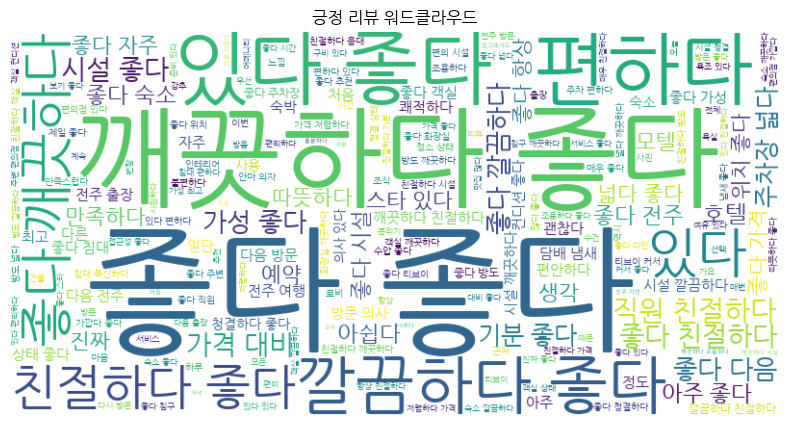

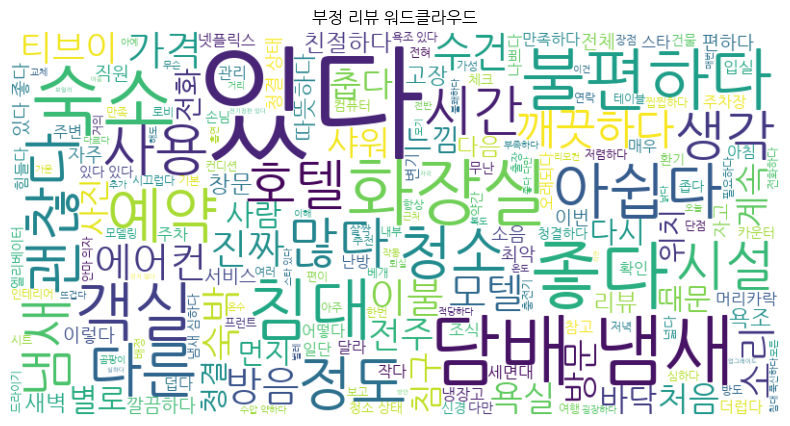

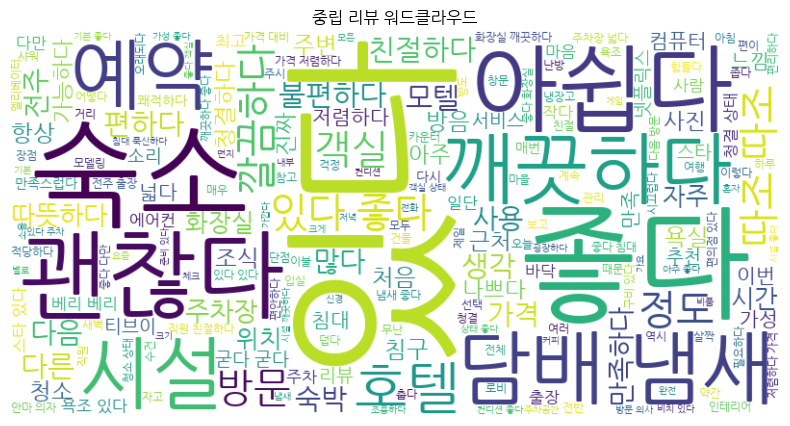

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

font_path = "C:/Windows/Fonts/NanumGothic.ttf"
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

for sentiment in ['긍정', '부정', '중립']:
    # 해당 감정의 모든 리뷰를 하나로 합치기
    texts = df[df['label'] == sentiment]['sentence'].dropna().astype(str)
    
    # 형태소 분석 + 불용어 제거 + 명사/형용사 필터링
    words = []
    for sentence in texts:
        for word, pos in okt.pos(sentence, stem=True):
            if pos in ['Noun', 'Adjective'] and word not in stopwords and len(word) > 1:
                words.append(word)
    
    # 워드클라우드용 문자열 생성
    text_filtered = ' '.join(words)

    wc = WordCloud(
        font_path="C:/Windows/Fonts/NanumGothic.ttf",  # 시스템에 맞게 변경
        background_color='white',
        width=800,
        height=400
    ).generate(text_filtered)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"{sentiment} 리뷰 워드클라우드")
    plt.show()

In [30]:
# ✅ 1. 데이터 불러오기
# 예: accommodation = 숙소명, sentence = 리뷰
import pandas as pd
from konlpy.tag import Okt
from collections import Counter

df = pd.read_csv("36000_reviews_label.csv", encoding="utf-8-sig")
df = df[['name', 'sentence']].dropna()
df['sentence'] = df['sentence'].astype(str)

# ✅ 3. 숙소별 키워드 추출 함수
def extract_keywords(texts, top_n=10):
    words = []
    for text in texts:
        try:
            tokens = okt.pos(text, stem=True)
            for word, pos in tokens:
                if pos in ['Noun', 'Adjective'] and word not in stopwords and len(word) > 1 and len(word) < 8:
                    words.append(word)
        except:
            continue
    return Counter(words).most_common(top_n)

# ✅ 4. 숙소별 키워드 추출 실행
result = []

for name, group in df.groupby('name'):
    keywords = extract_keywords(group['sentence'], top_n=10)
    result.append({
        '숙소명': name,
        '상위키워드': [kw for kw, _ in keywords]
    })

# ✅ 5. 결과 저장 및 확인
keywords_df = pd.DataFrame(result)
keywords_df.to_csv("숙소별_키워드_요약.csv", index=False, encoding="utf-8-sig")
print(keywords_df.head())

                숙소명                                           상위키워드
0           라한호텔 전주     [좋다, 있다, 마을, 호텔, 전주, 위치, 친절하다, 숙소, 수영장, 조식]
1  베스트웨스턴 플러스 전주 호텔  [좋다, 있다, 호텔, 전주, 마을, 깔끔하다, 숙소, 깨끗하다, 친절하다, 객실]
2              솔 호텔  [좋다, 있다, 깨끗하다, 친절하다, 깔끔하다, 숙소, 시설, 전주, 직원, 호텔]
3      완주 스페이스셔틀 전주    [좋다, 있다, 친절하다, 다음, 시설, 깔끔하다, 숙소, 일단, 개인, 상태]
4           전주 관광호텔      [좋다, 있다, 침대, 가격, 친절하다, 위치, 가성, 전주, 시설, 숙소]


In [33]:

# 🖼️ 5. 혼동 행렬 시각화
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import font_manager as fm

font_path = "C:/Windows/Fonts/NanumGothic.ttf"
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

unique_labels = sorted(df['label'].unique())
cm = confusion_matrix(y_test, gbc_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(cmap=plt.cm.Oranges)
plt.title("Gradient Boosting 혼동 행렬")
plt.show()


KeyError: 'label'

In [32]:

# 📊 6. 정밀도/재현율/F1-score 시각화
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, gbc_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose().iloc[:-3]

df_report[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title("Gradient Boosting 성능 지표 비교")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.show()


NameError: name 'gbc_pred' is not defined